### Laboratorium 4 - zadania

Dany jest zbiór obrazów wraz z etykietami - maskami segmentacji. Twoim zadaniem jest zaproponować metodę binaryzacji obrazów, zaimplementować odpowiednie metryki oceny i wykorzystać je do określenia jakości detekcji w zależności od parametrów metody.

Pytania zadane kursywą możesz traktować jako "zajawki" do sprawozdania.

Dołączony w zadaniu dataset jest podzbiorem datasetu dostępnego w oryginale na portalu [Kaggle](https://www.kaggle.com/longnguyen2306/bacteria-detection-with-darkfield-microscopy).

In [2]:
import os
from typing import Iterator, List, Tuple

import cv2
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

Do podanego zbioru danych zaimplementowany został poniższy loader. Możesz korzystać z niego albo przez interfejs listy (`loader[3]`) albo przez interfejs iteracyjny (`for sample in loader`). W obu przypadkach zwracana jest para (obraz, etykieta), gdzie obraz jest 3-kanałowym obrazem **RGB** a etykieta 1-kanałowym obrazem o wartościach 0 (tło) i 1 (obiekt-bakteria). Poniższa komórka zawiera przykład.

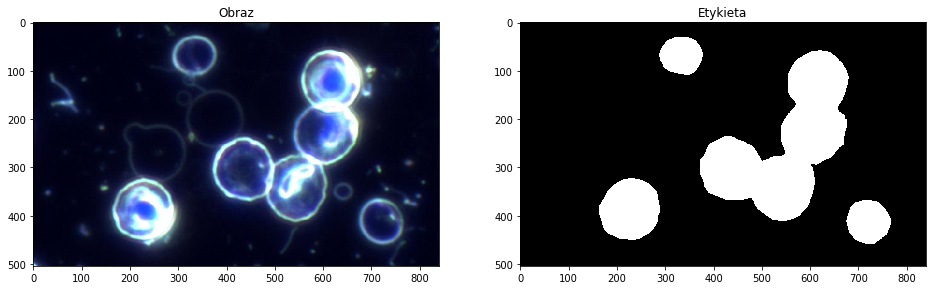

In [3]:
class BacteriaLoader:
    SUBSET = 89, 155
    def __init__(self, root:str, train:bool=True) -> None:
        """
        root (str): path to the folder containing 'images', 'masks' and 'meta.json'
        train (bool): if True, returns the calibration subset, otherwise the validation subset
        """
        image_names = os.listdir(os.path.join(root, 'images'))
        mask_names = os.listdir(os.path.join(root, 'masks'))
        valid_names = self.get_names()
        if any(name not in image_names or name not in mask_names for name in valid_names):
            raise FileNotFoundError("Dataset malformed: files missing.")
        image_names = [os.path.join(root, 'images', file_name) for file_name in valid_names]
        mask_names = [os.path.join(root, 'masks', file_name) for file_name in valid_names]
        test_image_names = image_names[::3]
        train_image_names = [name for name in image_names if name not in test_image_names]
        self.image_names = train_image_names if train else test_image_names
        test_mask_names = mask_names[::3]
        train_mask_names = [name for name in mask_names if name not in test_mask_names]
        self.mask_names = train_mask_names if train else test_mask_names

    def get_names(self) -> List[str]:
        return ['{:03d}.png'.format(i) for i in range(*self.SUBSET)]

    def __getitem__(self, index:int) -> Tuple[np.ndarray, np.ndarray]:
        image = cv2.imread(self.image_names[index])
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask_ = cv2.imread(self.mask_names[index], cv2.IMREAD_GRAYSCALE)
        mask = np.zeros_like(mask_, dtype=np.uint8)
        mask[mask_==1] = 1  # pozostałe obiekty ignorujemy
        return image, mask

    def __len__(self) -> int:
        return len(self.image_names)

    def __iter__(self) -> Iterator[Tuple[np.ndarray, np.ndarray]]:
        for i in range(len(self)):
            yield self[i]


loader = BacteriaLoader('BacteriaKaggle')
image, mask = loader[21]
f, (axi, axm) = plt.subplots(1, 2)
f.set_figwidth(16)
f.set_figheight(8)
axi.imshow(image, interpolation='none');
axi.set_title('Obraz');
axm.imshow(mask*100, interpolation='none', cmap='gray');
axm.set_title('Etykieta');

#### Zadanie 1 (1.0 pkt | 0.5 pkt)

Zaimplementuj w funkcji `detect_bacteria` taki algorytm przetwarzania obrazu, by uzyskać wizualnie akceptowalną binaryzację. Użyj operacji morfologicznych do odfiltrowania artefaktów. Nie staraj się na tym etapie dążyć do idealnych rezultatów - dokładny dobór parametrów algorytmu będzie jednym z następnych kroków.

Do testowania użyj poniższej komórki. Zwróć uwagę na interfejs `**params` - przekazywanie parametrów metody (np. wartości progów, rozmiary kerneli) tą drogą znacznie uprości pracę na dalszych etapach. W razie potrzeby, zapoznaj się z pythonowym mechanizmem [`kwargs`](https://book.pythontips.com/en/latest/args_and_kwargs.html#usage-of-kwargs).

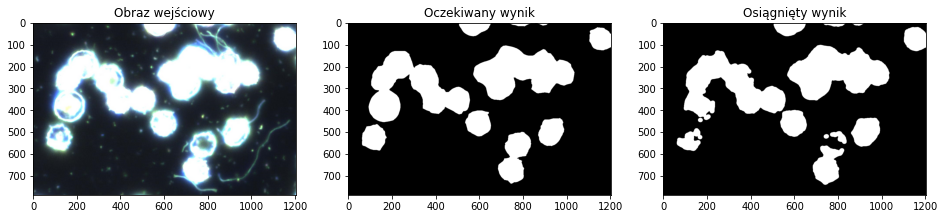

In [20]:
def detect_bacteria(image: np.ndarray, **params) -> np.ndarray:
    # wartości parametrów przekazuj w 'params', np.: params['threshold']
    # output = np.zeros_like(image[..., 0], dtype=np.uint8)
    output = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    T, output = cv2.threshold(output, params['threshold'], 1, cv2.THRESH_BINARY)
    kernel_size = params.get('kernel_size', 21)
    kernel_type = params.get('kernel_type', cv2.MORPH_ELLIPSE)
    erode_kernel = cv2.getStructuringElement(params.get('erode_kernel_type', kernel_type), (params.get('erode_kernel_size', kernel_size),)*2)
    dilate_kernel = cv2.getStructuringElement(params.get('dilate_kernel_type', kernel_type), (params.get('dilate_kernel_size', kernel_size),)*2)
    output = cv2.erode(output, erode_kernel)
    output = cv2.dilate(output, dilate_kernel)
#     output = cv2.dilate(output, dilate_kernel)
#     output = cv2.erode(output, erode_kernel)
    contours, hierarchy = cv2.findContours(output, mode=cv2.RETR_EXTERNAL, method=cv2.CHAIN_APPROX_SIMPLE)
    output = np.zeros_like(output)
    output = cv2.drawContours(output, contours=contours, contourIdx=-1, color=1, thickness=-1)
    return output

dev_image, dev_mask = loader[0] # sprawdź też inne przykłady, np. 9, 37
# dev_image, dev_mask = loader[9]
# dev_image, dev_mask = loader[37]

output = detect_bacteria(dev_image, threshold=190, kernel_size=21)

# wyświetlanie
f, (a_img, a_mask, a_pred) = plt.subplots(1, 3)
f.set_figwidth(16)
f.set_figheight(8)
a_img.imshow(dev_image)
a_img.set_title('Obraz wejściowy');
a_mask.imshow(dev_mask, cmap='gray', vmin=0, vmax=1)
a_mask.set_title('Oczekiwany wynik');
a_pred.imshow(output, cmap='gray', vmin=0, vmax=1)
a_pred.set_title('Osiągnięty wynik');

#### Zadanie 2 (1.0 pkt | 0.5 pkt)

Zaimplementuj funkcję `measure` w taki sposób, by wyliczała wybrane przez Ciebie metryki (uwzględnij co najmniej precyzję, czułość, oraz indeks Jaccarda) i zwracała je w formie słownika. Wykorzystaj ją do określenia błędu pomiędzy wynikiem działania twojej funkcji, a maską dla różnych wartości wybranych parametrów (patrz: przykład). Wykonaj testy dla kilku odróżniających się przykładów.  
_Co stanowi przyczynę błędów? Zwróć uwagę na specyfikę obrazów i zasady działania stosowanych algorytmów._

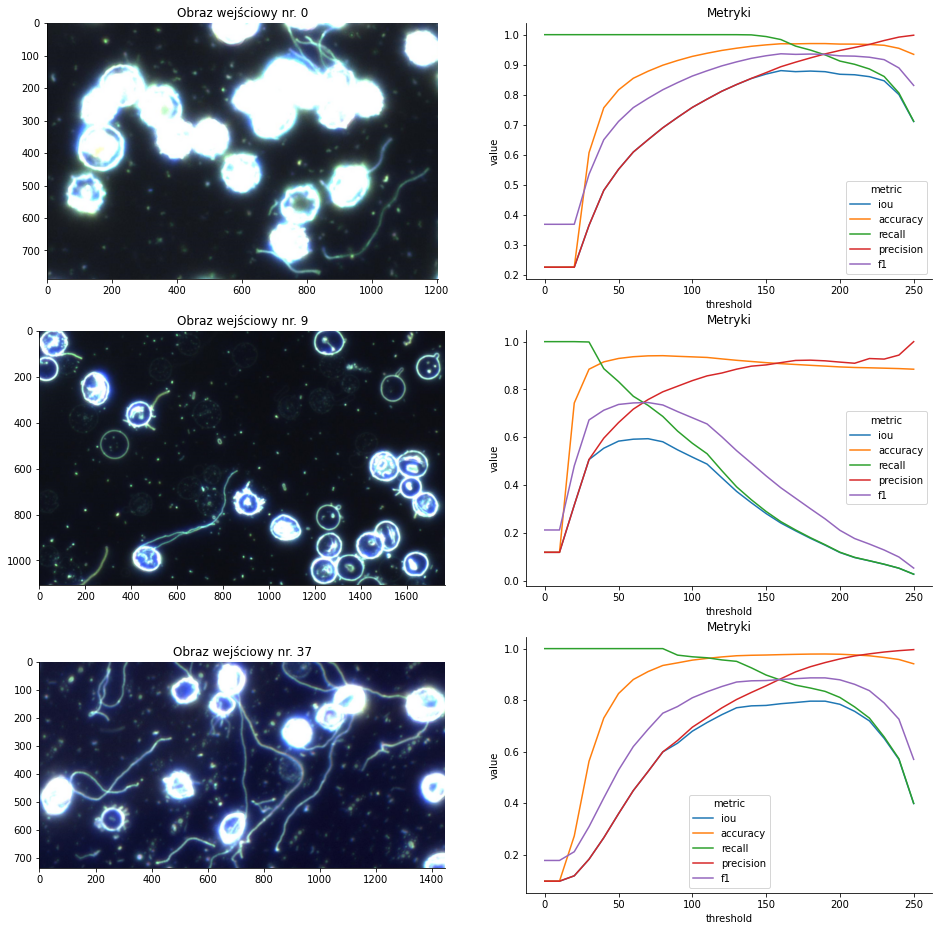

In [21]:
def measure(predicted, truth):
    epsilon = 1e-8
    tp = np.logical_and(predicted, truth).sum()
    iou = tp / (np.logical_or(predicted, truth).sum() + epsilon)
    accuracy = np.mean(predicted == truth)
    recall = tp / (truth.sum() + epsilon)
    precision = tp / (predicted.sum() + epsilon)
    f1 = 2 * recall * precision / (recall + precision + epsilon)
    return {'iou': iou, 'accuracy': accuracy, 'recall': recall, 'precision': precision, 'f1': f1}

indices = [0, 9, 37]

f, axes = plt.subplots(len(indices), 2)
f.set_figwidth(16)
f.set_figheight(16)


for i, idx in enumerate([0, 9, 37]):
    test_image, test_mask = loader[idx]
    results = []
    for threshold in range(0, 260, 10):
        output = detect_bacteria(test_image, threshold=threshold)
        m = measure(output, test_mask)
        for k, v in m.items():
            results.append(dict(
                threshold=threshold,
                metric=k,
                value=v,
            ))
    
    df = pd.DataFrame.from_records(results)
    axes[i, 0].imshow(test_image)
    axes[i, 0].set_title(f'Obraz wejściowy nr. {idx}');
    sns.lineplot(x='threshold', y='value', hue='metric', data=df, ax=axes[i, 1])
    axes[i, 1].set_title('Metryki');
        
# df = pd.DataFrame.from_records(results)
# fig, ax = plt.subplots(figsize=(10, 6))
# sns.lineplot(x='threshold', y='value', hue='metric', data=df, ax=ax)
sns.despine(f)

#### Zadanie 3 (1.0 pkt | 0.5 pkt)

Przeanalizuj wpływ wybranych parametrów na średnią jakość predykcji na całym zbiorze treningowym. Wybierz na tej podstawie najlepszą kombinację parametrów.  
_Zwracaj uwagę na odchylenie standardowe dla średniej. Czy w zbiorze występują próbki, z którymi Twój algorytm szczególnie sobie nie radzi?_

Jeśli starczy czasu: wykonaj drugą iterację kalibracji w oparciu o wyniki, starając się poprawić binaryzację dla "trudnych" przykładów.

In [22]:
from itertools import product


def param_generator(param_dict):
    for params in product(*param_dict.values()):
        yield {k: v for k, v in zip(param_dict.keys(), params)}

In [23]:
from tqdm.auto import tqdm

results_4 = []
param_dict = dict(
    threshold = list(range(0, 260, 30)),
    erode_kernel_size = [9, 21, 33],
    dilate_kernel_size = [9, 21, 33],
#     kernel_type = [cv2.MORPH_RECT, cv2.MORPH_CROSS, cv2.MORPH_ELLIPSE],
)
for params in tqdm(list(param_generator(param_dict))):
    for i, (train_image, train_mask) in enumerate(loader):
        output = detect_bacteria(train_image, **params)
        m = measure(output, train_mask)
        for k, v in m.items():
            results_4.append(dict(
                **params,
                id=i,
                metric=k,
                value=v,
            ))

  0%|          | 0/81 [00:00<?, ?it/s]

In [24]:
df = pd.DataFrame.from_records(results_4)
df = df[df.metric.isin(['iou'])]
df.head()

threshold  erode_kernel_size  dilate_kernel_size  id metric     value
0           0                  9                   9   0    iou  0.226354
5           0                  9                   9   1    iou  0.159993
10          0                  9                   9   2    iou  0.099362
15          0                  9                   9   3    iou  0.136949
20          0                  9                   9   4    iou  0.094414

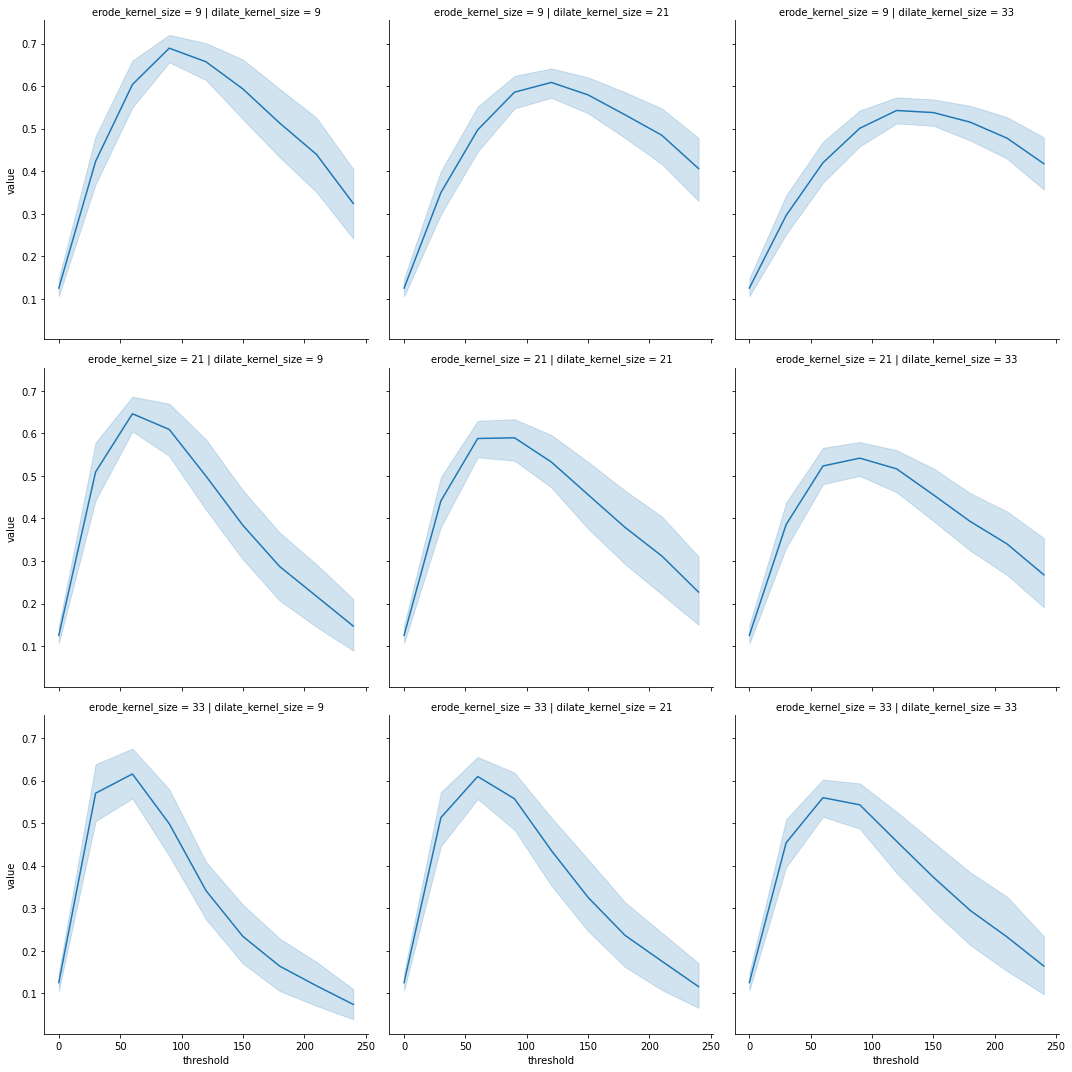

In [25]:
g = sns.FacetGrid(row='erode_kernel_size', col='dilate_kernel_size', data=df, height=5)
g.map_dataframe(sns.lineplot, x='threshold', y='value', hue='metric');

In [26]:
_df = df.copy()
_df_grouped = _df[['threshold', 'erode_kernel_size', 'dilate_kernel_size', 'metric', 'value']].groupby(['threshold', 'erode_kernel_size', 'dilate_kernel_size', 'metric'])
_df_agg = _df_grouped.agg(['mean', 'std', 'min', 'max']).reset_index()
_df_agg.columns = ["_".join(filter(bool, c)) for c in _df_agg.columns.to_flat_index()]
ranking = _df_agg.sort_values('value_mean', ascending=False).head()
ranking

threshold  erode_kernel_size  dilate_kernel_size metric  value_mean  \
27         90                  9                   9    iou    0.689130   
36        120                  9                   9    iou    0.657071   
21         60                 21                   9    iou    0.645986   
24         60                 33                   9    iou    0.615484   
25         60                 33                  21    iou    0.609562   

    value_std  value_min  value_max  
27   0.109972   0.458505   0.939713  
36   0.154422   0.205033   0.905318  
21   0.149995   0.220738   0.927310  
24   0.196462   0.044824   0.895394  
25   0.169334   0.081101   0.917343

In [27]:
best_params = ranking[['threshold', 'erode_kernel_size', 'dilate_kernel_size']].iloc[0].to_dict()
best_params

{'threshold': 90, 'erode_kernel_size': 9, 'dilate_kernel_size': 9}

In [28]:
_df_best = df.loc[(df[list(best_params)] == pd.Series(best_params)).all(axis=1)].sort_values('value', ascending=False)
_df_best.head()

threshold  erode_kernel_size  dilate_kernel_size  id metric     value
6065         90                  9                   9  25    iou  0.939713
6000         90                  9                   9  12    iou  0.840781
6075         90                  9                   9  27    iou  0.835516
6040         90                  9                   9  20    iou  0.829522
5995         90                  9                   9  11    iou  0.811777

In [29]:
_df_best.tail()

threshold  erode_kernel_size  dilate_kernel_size  id metric     value
6125         90                  9                   9  37    iou  0.535173
6115         90                  9                   9  35    iou  0.532443
6140         90                  9                   9  40    iou  0.502300
6130         90                  9                   9  38    iou  0.478965
6150         90                  9                   9  42    iou  0.458505

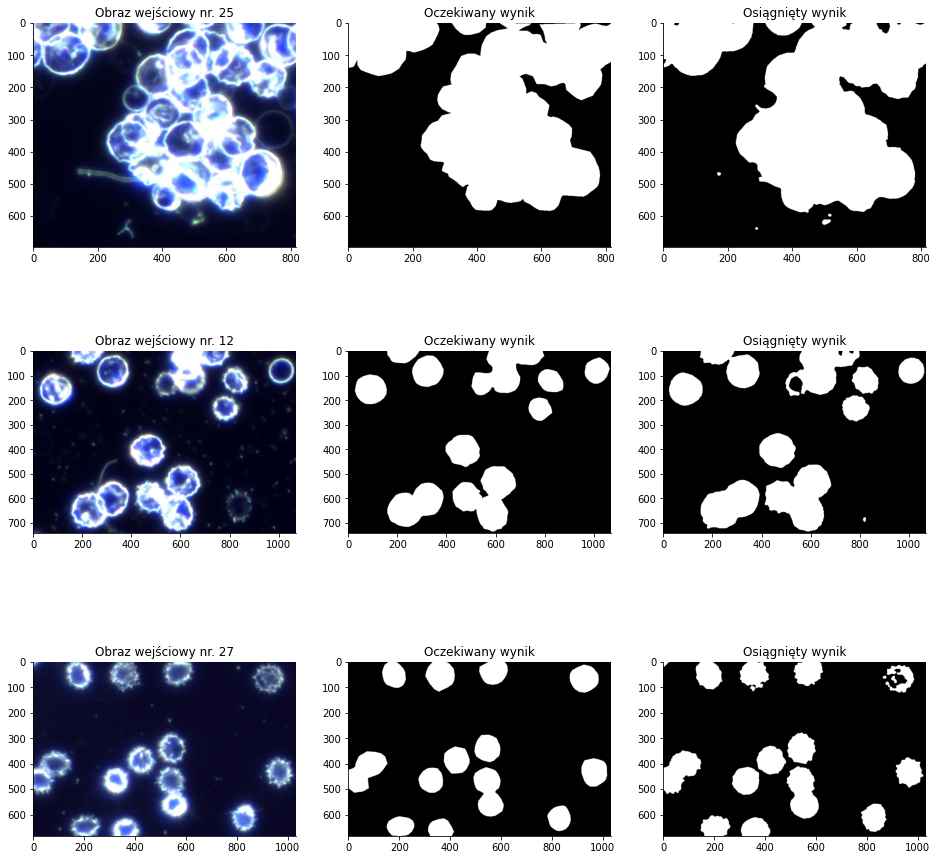

In [30]:
rows = _df_best.head(3)

f, axes = plt.subplots(len(rows), 3)
f.set_figwidth(16)
f.set_figheight(16)


for i, (_, row) in enumerate(rows.iterrows()):
    test_image, test_mask = loader[row.id]
    output = detect_bacteria(test_image, **row.to_dict())
    axes[i, 0].imshow(test_image)
    axes[i, 0].set_title(f'Obraz wejściowy nr. {row.id}');
    axes[i, 1].imshow(test_mask, cmap='gray')
    axes[i, 1].set_title('Oczekiwany wynik');
    axes[i, 2].imshow(output, cmap='gray')
    axes[i, 2].set_title('Osiągnięty wynik');
        
sns.despine(f)

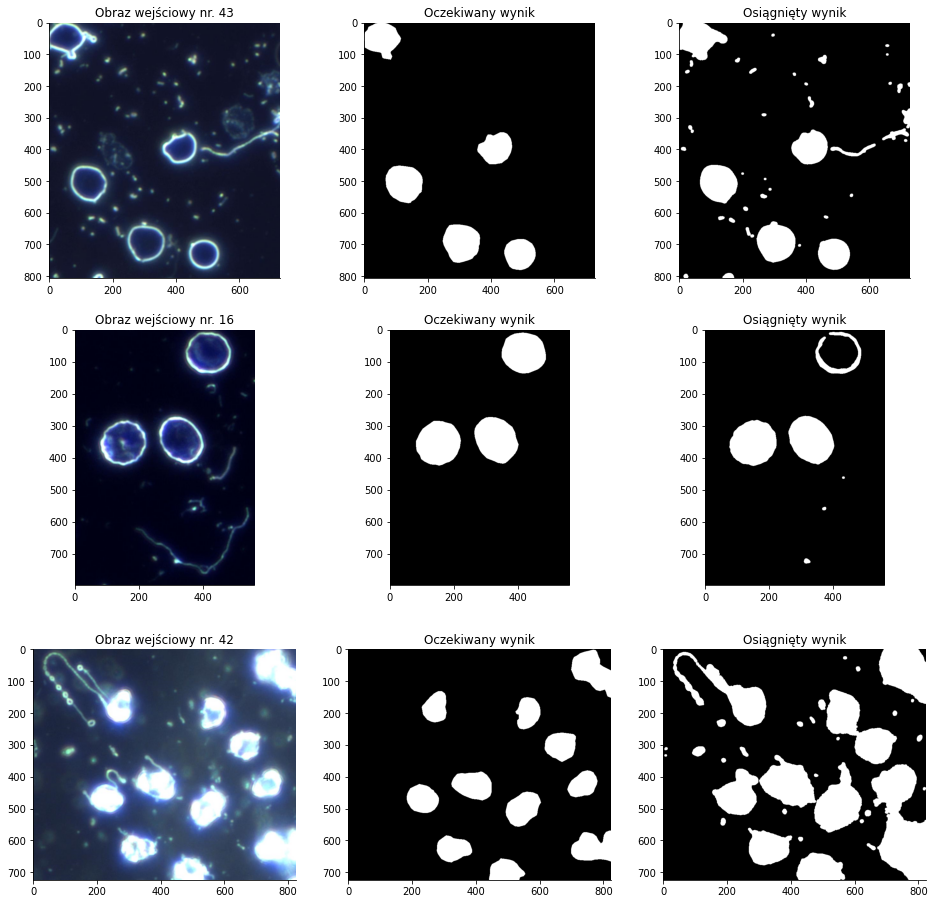

In [36]:
rows = _df_best.tail(3)
rows = _df_best[_df_best.id.isin([43, 42, 16])]

f, axes = plt.subplots(len(rows), 3)
f.set_figwidth(16)
f.set_figheight(16)


for i, (_, row) in enumerate(rows.iterrows()):
    test_image, test_mask = loader[row.id]
    output = detect_bacteria(test_image, **row.to_dict())
    axes[i, 0].imshow(test_image)
    axes[i, 0].set_title(f'Obraz wejściowy nr. {row.id}');
    axes[i, 1].imshow(test_mask, cmap='gray')
    axes[i, 1].set_title('Oczekiwany wynik');
    axes[i, 2].imshow(output, cmap='gray')
    axes[i, 2].set_title('Osiągnięty wynik');
        
sns.despine(f)

#### Zadanie 4 (0.0 pkt | 0.5 pkt)

Przetestuj działanie tak skalibrowanego algorytmu na zbiorze walidacyjnym.  
_Jak wyniki mają się do tych ze zbioru kalibracyjnego? Dlaczego?_

In [37]:
val_loader = BacteriaLoader(root='BacteriaKaggle', train=False)

In [38]:
from tqdm.auto import tqdm

val_results = []
for i, (val_image, val_mask) in enumerate(val_loader):
    output = detect_bacteria(val_image, **best_params)
    m = measure(output, val_mask)
    for k, v in m.items():
        val_results.append(dict(
            **best_params,
            id=i,
            metric=k,
            value=v,
        ))

In [39]:
df_val = pd.DataFrame.from_records(val_results)
df_val = df_val[df_val.metric.isin(['iou'])]
df_val.head()

threshold  erode_kernel_size  dilate_kernel_size  id metric     value
0          90                  9                   9   0    iou  0.750082
5          90                  9                   9   1    iou  0.655174
10         90                  9                   9   2    iou  0.767792
15         90                  9                   9   3    iou  0.748971
20         90                  9                   9   4    iou  0.682266

In [40]:
_df = df_val.copy()
_df_grouped = _df[['threshold', 'erode_kernel_size', 'dilate_kernel_size', 'metric', 'value']].groupby(['threshold', 'erode_kernel_size', 'dilate_kernel_size', 'metric'])
_df_agg = _df_grouped.agg(['mean', 'std', 'min', 'max']).reset_index()
_df_agg.columns = ["_".join(filter(bool, c)) for c in _df_agg.columns.to_flat_index()]
_df_agg

threshold  erode_kernel_size  dilate_kernel_size metric  value_mean  \
0         90                  9                   9    iou    0.672467   

   value_std  value_min  value_max  
0   0.117411   0.454034   0.857953